In [1]:
import pandas as pd
from obspy import read_events
from utility import get_ID_mapping_dict, \
    get_gcmt_from_event, extract_gcmt_from_string, find_file
from tqdm import tqdm
from os import listdir
from obspy.core.event import Catalog


In [2]:
base_file = "base_database_frame"
df = pd.read_pickle(base_file)

# Database - Creation of new event folder 
The new event folder contains one file for each event in the ndk database of all moment tensors.

In [2]:
%time cat = read_events("jan76_dec20.ndk")
# output: 1m 38s loading event

print(cat)

CPU times: user 1min 35s, sys: 1.22 s, total: 1min 36s
Wall time: 1min 37s
56832 Event(s) in Catalog:
1976-01-01T01:29:53.400000Z | -29.250, -176.960 | 7.25 Mwc
1976-01-05T02:31:44.700000Z | -13.420,  -75.140 | 5.65 Mwc
...
2020-12-31T19:50:21.800000Z |  -0.680, +146.830 | 5.18 Mwc
2020-12-31T23:12:39.300000Z |  -9.020, +119.060 | 4.96 Mwc
To see all events call 'print(CatalogObject.__str__(print_all=True))'


In [21]:
# define the event folder
event_folder = "events"

# get the mapping dictionary
map_dict = get_ID_mapping_dict()

# check the event folder
list_files = listdir(event_folder)
xml_files = list(filter(lambda filename: "xml" in filename, list_files))
print(f"The folder has {len(xml_files)} xml-files.")

The folder has 56832 xml-files.


A loop that creates a new catalog quake xml file for each event.


In [14]:
write_events = False
if write_events:
    for event in tqdm(cat):
        # create a new catalog for each event
        file_cat = Catalog()
        file_cat.append(event)
        # get the IDs from the event and create a corresponding filename for this single event
        gcmt_id = get_gcmt_from_event(event)
        event_id = map_dict[gcmt_id]
        filename = f"{event_folder}/{gcmt_id}-{event_id}.xml"
        # write the catalog to file
        file_cat.write(filename, format="QUAKEML")

## Test functionality
Check if all events are in the folder.
* get a test dataframe subset
* get event metadata from the catalog files
* plot catalog

In [22]:
test_df = pd.read_pickle("example_dataset_chile_test")
event_folder = "events"

In [4]:
test_df.shape

(780, 22)

In [8]:
def create_catalog_from_frame(df):
    """ given a dataframe containing events with GCMT and event ID return an Obspy catalog with the same events
    """
    event_list = df.event_id.to_list()
    catalog = Catalog()
    for event_id in tqdm(event_list):
        filename = find_file(event_folder, event_id, return_path_filename=True)
        event_cat = read_events(filename)
        new_event = event_cat[0]
        catalog.append(new_event)
    return catalog

In [9]:
# test of the function
test_cat =create_catalog_from_frame(test_df)

100%|█████████████████████████████████████████| 780/780 [00:29<00:00, 26.12it/s]


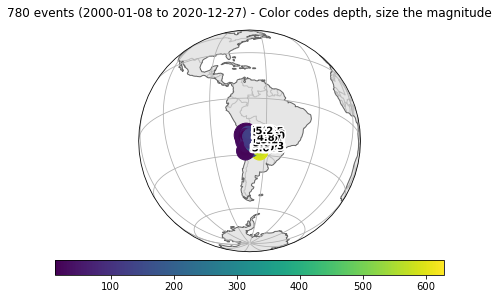

In [13]:
event_plot = test_cat.plot(projection="ortho")

## Analysis of test dataset
The test dataset has 780 events. 
* What is the magnitude distribution?

<AxesSubplot:>

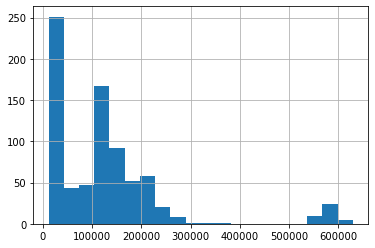

In [26]:
test_df.depth.hist(bins=20)

<AxesSubplot:>

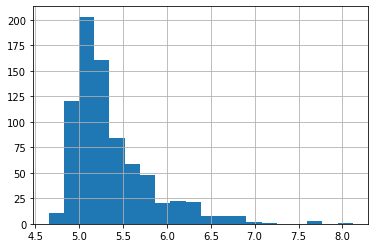

In [27]:
test_df.mag.hist(bins=20)

<AxesSubplot:xlabel='mag', ylabel='depth'>

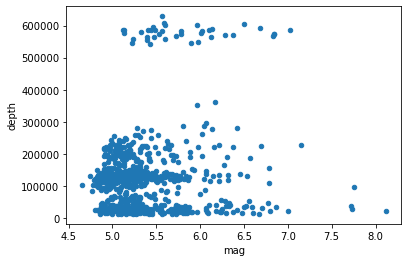

In [29]:
test_df.plot.scatter("mag", "depth")

## Test of ID extraction
Is every item in the catalog accounted for? Are the lists from an information perspective identical?

In [8]:
list_gcmt = df.gcmt_id.to_list()

In [12]:
extracted_gcmts = []
for event in tqdm(cat):
    string =event.resource_id.resource_id
    gcmt_string = extract_gcmt_from_string(string)
    extracted_gcmts.append(gcmt_string)

100%|█████████████████████████████████| 56832/56832 [00:00<00:00, 435388.99it/s]


In [13]:
# check if the gcmt_string from the catalog is in the list of the dataframe
false_count = 0
for gcmt_string in tqdm(extracted_gcmts):
    if gcmt_string not in list_gcmt:
        false_count += 1
print(false_count)
# answer: because every string is in the list

100%|███████████████████████████████████| 56832/56832 [00:17<00:00, 3293.10it/s]

0
